In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class cell:
    def __init__(self, prim, xmin, xmax, id, children=[], parent=None):
        self.prim = prim
        self.id = id
        self.children = children
        self.parent = parent
        self.xmin = xmin
        self.xmax = xmax
        self.x = (xmax + xmin) / 2

        self.need_refine = False
        self.need_coarse = False

        self.activating = True

        self.level = 0

    def update(self, prim):
        self.prim = prim

In [ ]:
class cell:
    def __init__(self, prim, xmin, xmax, id, children=[], parent=None, level=0): 
        self.prim = prim
        self.id = id
        self.children = children # Stores child IDs, not child objects
        self.parent = parent     # Stores parent ID, not parent object
        self.xmin = xmin
        self.xmax = xmax
        self.x = (xmax + xmin) / 2
        self.dx = xmax - xmin

        self.need_refine = False
        self.need_coarse = False

        self.activating = True 
        self.level = level

    def update(self, prim):
        self.prim = prim

    def __repr__(self):
        return (f"Cell(id={self.id}, L={self.level}, x=[{self.xmin:.2f}, {self.xmax:.2f}], "
                f"prim={self.prim:.2f}, activating={self.activating})")


In [ ]:
# Grid that stores box
class grid:
    def __init__(self, L, N):
        self.L = L
        self.N = N
        self.dx0 = L / N
        self.grid = {} 
        self.id_counter = 0

        # Initialization
        for n in range(self.N):
            cell_id = self.get_next_id()
            new_cell = cell(prim=0.0, xmin=n * self.dx0, xmax=(n + 1) * self.dx0,
                            id=cell_id, level=0)
            self.grid[cell_id] = new_cell 

    def get_next_id(self):
        """Generates a unique ID for a new cell."""
        new_id_val = self.id_counter
        self.id_counter += 1
        return new_id_val

    def get_cell_by_id(self, cell_id):
        """Retrieves a cell object from the central dictionary by its ID (O(1) lookup)."""
        return self.grid.get(cell_id)

    def get_all_active_cells(self):
        """
        Retrieves all 'activating' (active/leaf) cells from the entire grid hierarchy.
        This traverses the tree using BFS and looks up child objects by ID.
        """
        active_cells = []
        for cell in self.grid.values():
            if cell.activating:
                active_cells.append(cell)

        return active_cells

    def refine_cell(self, parent_cell_id):
        """
        Refines a specified parent cell into two children.
        Manages ID assignment, updates cell links (parent/children), and updates the grid dictionary.
        """
        parent_cell = self.get_cell_by_id(parent_cell_id)
        if not parent_cell:
            raise ValueError(f"Error: Parent cell with ID {parent_cell_id} not found for refinement.")

        if not parent_cell.activating: # Already refined
            raise TypeError(f"Cell with ID {parent_cell_id} is already refined (not activating).")

        # Create two new child cells, which inherit primitive variables
        child_level = parent_cell.level + 1
        child_left_id = self.get_next_id()
        child_right_id = self.get_next_id()

        child_left = cell(
            prim=parent_cell.prim,
            xmin=parent_cell.xmin, xmax=parent_cell.x,
            id=child_left_id, level=child_level, parent=parent_cell_id 
        )
        child_right = cell(
            prim=parent_cell.prim,
            xmin=parent_cell.x, xmax=parent_cell.xmax,
            id=child_right_id, level=child_level, parent=parent_cell_id
        )

        parent_cell.children.append(child_left_id)
        parent_cell.children.append(child_right_id)

        parent_cell.activating = False

        # Add new children to the central grid dictionary
        self.grid[child_left_id] = child_left
        self.grid[child_right_id] = child_right

        return child_left_id, child_right_id

    def coarsen_cell(self, parent_cell_id):
        """
        Coarsens a specified parent cell by removing its children from the hierarchy.
        Removes children (and their sub-children) from the central grid dictionary.
        """
        parent_cell = self.get_cell_by_id(parent_cell_id)
        if not parent_cell:
            raise ValueError(f"Error: Parent cell with ID {parent_cell_id} not found for coarsening.")

        if parent_cell.activating or not parent_cell.children:
            raise TypeError(f"Cell with ID {parent_cell_id} is already activating or has no children to coarsen.")

        # Recursively remove children
        def _remove_subtree_from_grid(cell_id_to_remove):
            cell_obj = self.get_cell_by_id(cell_id_to_remove)
            if cell_obj:
                for child_id in list(cell_obj.children):
                    _remove_subtree_from_grid(child_id)
                if cell_id_to_remove in self.grid: 
                    del self.grid[cell_id_to_remove]

        for child_id in list(parent_cell.children):
            _remove_subtree_from_grid(child_id)

        parent_cell.children = [] 
        parent_cell.activating = True

In [31]:
def plot_amr_grid(grid_instance, title="AMR Grid Structure"):
    """
    Plots the 1D AMR grid hierarchy on a number line.
    Visualizes 'activating' cells (leaf nodes) using their level for vertical offset.
    """
    active_cells = grid_instance.get_all_active_cells()

    if not active_cells:
        print("No active cells to plot.")
        return

    min_x = min(cell_obj.xmin for cell_obj in active_cells)
    max_x = max(cell_obj.xmax for cell_obj in active_cells)

    # Max level might be 0 if no refinement, so handle it
    max_level = max(cell_obj.level for cell_obj in active_cells) if active_cells else 0
    y_offset_multiplier = 0.05 * (max_x - min_x) # Adjust for desired vertical spacing

    fig, ax = plt.subplots(figsize=(12, 6))

    plotted_levels = set() # To ensure unique labels in legend

    for cell_obj in active_cells:
        x_start = cell_obj.xmin
        x_end = cell_obj.xmax
        level = cell_obj.level
        cell_id = cell_obj.id

        y_pos = level * y_offset_multiplier

        # Add label only once per level for the legend
        label_text = None
        if level not in plotted_levels:
            label_text = f'Level {level}'
            plotted_levels.add(level)

        ax.plot([x_start, x_end], [y_pos, y_pos],
                linewidth=2 + level*0.5, # Thicker lines for finer levels
                color='blue',
                marker='|', markersize=8, markeredgewidth=1, # Show cell boundaries
                label=label_text)

        # Add cell ID and level as text on the plot
        ax.text(cell_obj.x, y_pos + y_offset_multiplier * 0.1,
                f"ID:{cell_id}\nL:{level}",
                fontsize=8, ha='center', va='bottom', color='black')

    ax.set_title(title)
    ax.set_xlabel("X-coordinate")
    ax.set_yticks([]) # Hide y-axis ticks as it's a conceptual "number line"
    ax.grid(axis='x', linestyle='--', alpha=0.7) # Grid lines only on x-axis

    # Set x-axis limits slightly beyond the min/max x of cells for padding
    ax.set_xlim(min_x - 0.05 * (max_x - min_x), max_x + 0.05 * (max_x - min_x))

    # Show legend only if there are multiple levels
    if len(plotted_levels) > 1:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

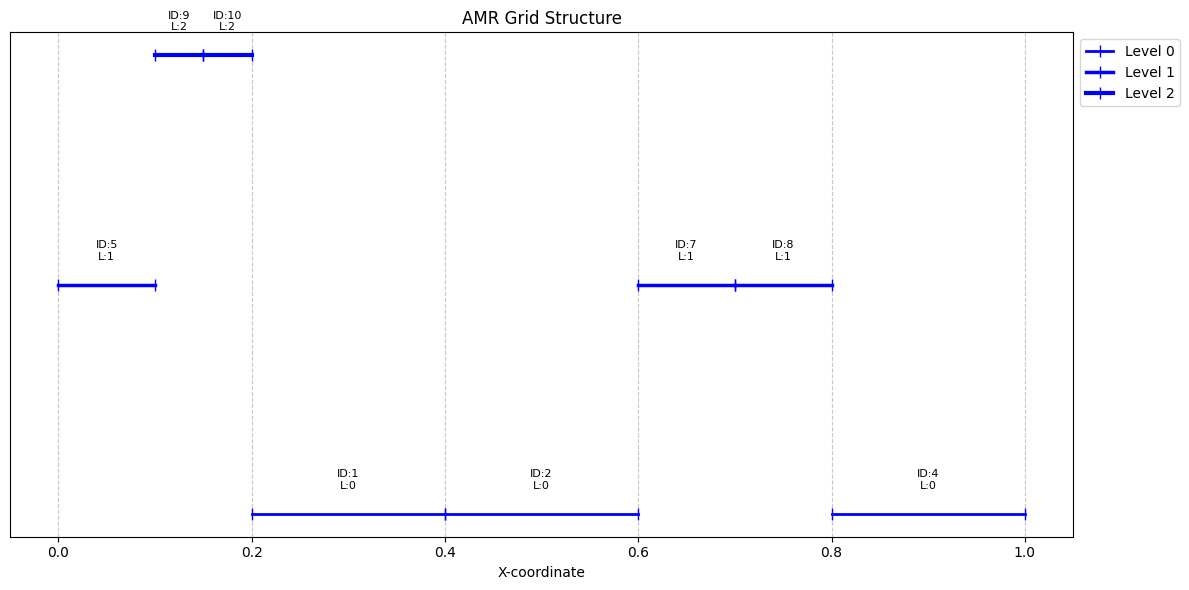

In [56]:
grid_0 = grid(L=1, N=5)
grid_0.refine_cell(0)
grid_0.refine_cell(3)
grid_0.refine_cell(6)
plot_amr_grid(grid_0)